In [1]:
library(enrichR)
library(Seurat)
library(cluster)
library(dplyr)
library(tidyr)

Welcome to enrichR
Checking connection ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is available!

WormEnrichr ... 
Connection is available!

YeastEnrichr ... 
Connection is available!

FishEnrichr ... 
Connection is available!

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
prepare_CellLayers <- function(sobj,res_search){
   
    # Resolution grid search
    modularity_list <- list()
    for (i in seq_along(res_search)) {
        out <- capture.output(sobj <- FindClusters(sobj, resolution=res_search[[i]]), type =  "output")
        sobj@meta.data$'seurat_clusters' <- NULL
        res_name <- paste('res.',res_search[[i]],sep='')
        modularity_list[[res_name]] <- as.numeric(unlist(strsplit(x = out[7], split = ":"))[2])
        names(sobj@meta.data)[length(names(sobj@meta.data))]<-res_name

    }
    mod_df <- stack(modularity_list)
    colnames(mod_df) <- c('modularity', 'resolution')    
    sil_list <- compute_silhouette_score(as.character(mod_df$'resolution'),sobj)
    write.csv(mod_df, '../Data/PBMC/pbmc_modularity.csv')
    return(list('sobj'=sobj, 'mod'=mod_df, 'sil'=sil_list))
}


compute_silhouette_score <- function(res,sobj){
    sil_list <- list()
    for (j in 1:length(res)) {

        Idents(sobj) <- res[j]
        clusters <- Idents(sobj)
        dist.matrix <- dist(x = Embeddings(object = sobj[['pca']])[, 1:30])

        sil <- silhouette(x = as.numeric(x = as.factor(x = clusters)), dist = dist.matrix)
        sil_summary <- aggregate(sil[,3], list(sil[,1]), mean)
        sil_summary$Group.1 <- sil_summary$Group.1 - 1
        colnames(sil_summary) <- c(res[j], 'sil')
        sil_list[[res[j]]] <- sil_summary
    }
    return(sil_list)
}

In [3]:
sobj <- readRDS('../Data/PBMC/pbmc3k.rds')

In [4]:
Idents(sobj) <- 'seurat_annotations'
sobj <- subset(x = sobj, downsample = 100, subset=seurat_annotations!="<NA>")

Centering and scaling data matrix

PC_ 1 
Positive:  IL32, CD3D, CD3E, CTSW, GZMA, CST7, LDHB, CD247, LTB, NKG7 
	   STK17A, TPT1, CD2, CCL5, ACAP1, HOPX, PRF1, FGFBP2, ALOX5AP, GZMB 
	   NCR3, SELL, GZMH, GIMAP5, GNLY, CCL4, GZMK, KLRG1, ARPC5L, AQP3 
Negative:  CST3, LST1, AIF1, FTH1, FTL, CFD, TYMP, SERPINA1, CD68, IFITM3 
	   COTL1, LYZ, TYROBP, FCER1G, CTSS, FCN1, SAT1, SPI1, CFP, PSAP 
	   IFI30, LGALS1, S100A9, NPC2, S100A11, RP11-290F20.3, MS4A7, TIMP1, OAZ1, LGALS3 
PC_ 2 
Positive:  SDPR, GNG11, PF4, GP9, SPARC, PTCRA, TUBB1, PPBP, ITGA2B, TMEM40 
	   HIST1H2AC, MMD, AP001189.4, NRGN, CLU, CD9, ACRBP, RGS18, CA2, TSC22D1 
	   TREML1, F13A1, LY6G6F, GP1BA, CMTM5, C2orf88, SEPT5, CLEC1B, MYL9, MAP3K7CL 
Negative:  RPS2, TMSB10, S100A4, COX4I1, TPT1, S100A6, JUNB, S100A11, S100A10, FOS 
	   TYROBP, ZFP36, VIM, HLA-DPA1, LGALS1, CTSS, LST1, RBM3, IFITM2, CD48 
	   RAC2, TYMP, PYCARD, IFI6, FCN1, EMP3, C1orf162, IFITM3, AIF1, IFI30 
PC_ 3 
Positive:  CD79A, MS4A1, HLA-DRA, HLA-DQA

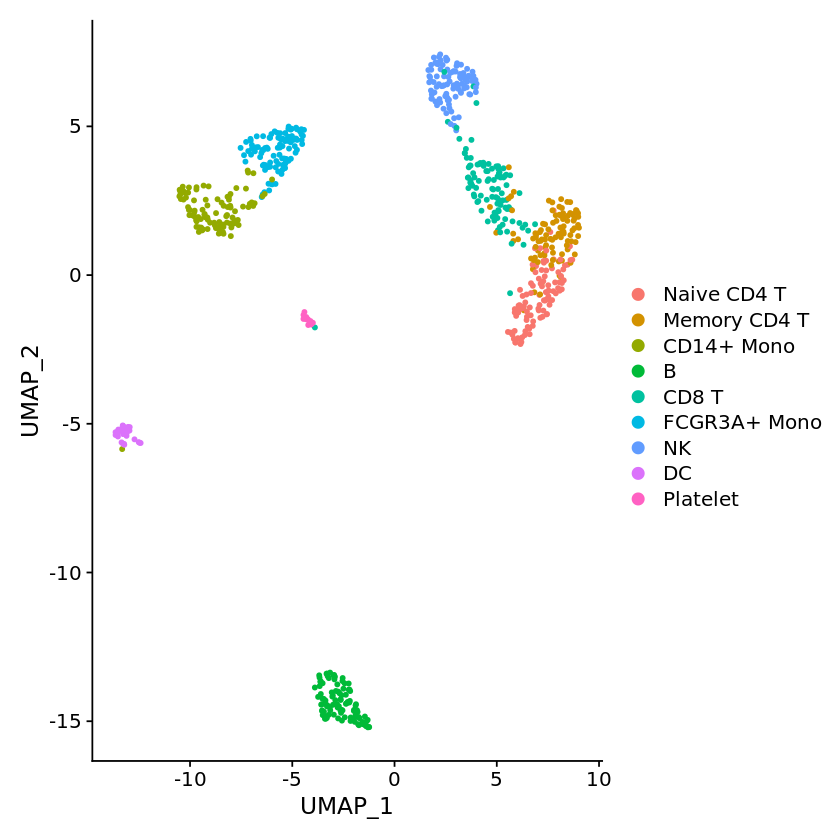

In [5]:
# Basic Seurat analysis
sobj[["percent.mt"]] <- PercentageFeatureSet(sobj, pattern = "^MT-")
sobj <- subset(sobj, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
sobj <- NormalizeData(sobj, normalization.method = "LogNormalize", scale.factor = 10000)
sobj <- FindVariableFeatures(sobj, selection.method = "vst", nfeatures = 2000)
all.genes <- rownames(sobj)
sobj <- ScaleData(sobj, features = all.genes)
sobj <- RunPCA(sobj, features = VariableFeatures(object = sobj))
sobj <- JackStraw(sobj, num.replicate = 100)
sobj <- ScoreJackStraw(sobj, dims = 1:20)
sobj <- FindNeighbors(sobj, dims = 1:10)
sobj <- RunUMAP(sobj, dims = 1:10)
DimPlot(sobj, reduction = "umap")

In [6]:
cl.prep <- prepare_CellLayers(sobj, seq(0.1, 0.5, by=0.1))

In [7]:
for(i in seq_along(cl.prep$sil)){
    cl.prep$sil[i][[1]][,1] <- paste(colnames(cl.prep$sil[i][[1]])[1], cl.prep$sil[i][[1]][,1], sep='_')
    colnames(cl.prep$sil[i][[1]])[1] <- "res"
    cl.prep$sil[i][[1]] <- cl.prep$sil[i][[1]] 
}
sil_df <- Reduce(function(...) full_join(..., by = c('sil', 'res')), cl.prep$sil)
colnames(sil_df) <- c('res_cluster', 'sil')

In [12]:
write.csv(sil_df, '../Data/PBMC/pbmc_silhouette_scores.csv')
write.csv(t(as.matrix(cl.prep$sobj@assays$RNA@data)), '../Data/PBMC/PBMC_exp.csv')
write.csv(cl.prep$sobj@meta.data, '../Data/PBMC/PBMC_meta.csv')
saveRDS(cl.prep$sobj,'../Data/PBMC/pbmc3k_CellLayers.rds')